In [110]:
# just for easier debugging
from typing import *
# phase 1 imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn.base
from distributed.utils_test import throws
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
# phase 2 imports
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
# phase 3 imports
# 3-1
from collections import Counter
from scipy.stats import entropy
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
# 3-2
from time import time
from sklearn import tree
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
# 3-3
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier

In [81]:
# functions to redo phase 1
def get_outliers(column: pd.Series):
    lower_quartile = column.quantile(0.25)
    upper_quartile = column.quantile(0.75)
    iqr = upper_quartile - lower_quartile
    return column[(column < lower_quartile - 1.5*iqr) | (column > upper_quartile + 1.5*iqr)]
def iterative_reformat(processes_ptr: pd.DataFrame, connections_ptr: pd.DataFrame, do_clean=True) -> pd.DataFrame:
    connections_ptr['ts'] = pd.to_datetime(connections_ptr['ts'])
    processes_ptr['ts'] = pd.to_datetime(processes_ptr['ts'])
    merged = processes_ptr.merge(connections_ptr, on=['ts', 'imei', 'mwra'], how='inner')
    merged['mwra'] = merged['mwra'].astype('int64')
    merged.drop(columns=['ts', 'imei'], inplace=True)
    if not do_clean:
        return merged
    to_drop = []
    # handle null values and outliers
    for column in merged.columns:
        # if more than 5% are NaN values or more than 5% are outliers, we don't use that column
        column_outliers = get_outliers(merged[column])
        if ((merged[column].isna().sum()/merged.shape[0] > 0.05) or 
            (column_outliers.shape[0] / merged.shape[0] > 0.05)):
            to_drop.append(column)
            continue
        # if there are some null values, we replace the data that's neutral in respect to mwra
        if merged[column].isnull().any():
            # we get means of the distributions for rows with present and non-present malware related activity
            means_per_mwra = merged.groupby('mwra')[column].mean()
            # we average those means, meaning the manufactured value won't be likely to affect predicted mwra 
            imputed_value = means_per_mwra.mean()
            merged[column].fillna(imputed_value, inplace=True)
        #  if there are any outliers, we replace them with the edge values. If we clipped all outliers, 
        #  we would clutter way too much data together, so we clip only the most extreme ones
        if column_outliers.shape[0]:
            iqr = stats.iqr(merged[column])
            lower_limit = merged[column].quantile(0.25)  - 2.5 * iqr
            upper_limit = merged[column].quantile(0.75)  + 2.5 * iqr
            merged[column] = merged[column].clip(lower=lower_limit, upper=upper_limit)
    return merged.drop(columns=to_drop)
# functions to redo phase 2

In [3]:
# getting the data from previous phases
connections, processes, = (pd.read_csv('data/connections.csv', sep='\t', keep_default_na=False, na_values=''), 
                           pd.read_csv('data/processes.csv', sep='\t', keep_default_na=False, na_values=''),)
combined_table = iterative_reformat(processes, connections)
X = combined_table.drop(columns=['mwra'])
y = combined_table['mwra']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Phase 3: Machine Learning
Martin Horský 50%, Janka Krajčíková 50%

# Phase 3-1: Implementing ID3 Classifier  

## 3-1A: Implementation

As we are dealing with continuous data, we will be using a different version of the ID3 algorithm opposed to the one shown in the lecture.  
Our implementation was inspired by the following implementation:  
https://www.geeksforgeeks.org/iterative-dichotomiser-3-id3-algorithm-from-scratch/

In [4]:
def _calculate_entropy(data):
    counts = np.bincount(data)
    probabilities = counts / len(data)
    return entropy(probabilities, base=2) # base=2 to use log2


def _bin_df(df: np.array):
    def _bin_column(column):
        bins = np.linspace(min(column), max(column)+0.01, 10) # +0.01 so max is included
        indices = np.digitize(column, bins)
        return np.array([(bins[_-1] + bins[_]) / 2 for _ in indices])
    
    for column_index in range(df.shape[1]):
        df[:, column_index] = _bin_column(df[:, column_index])
    return df


class ID3classifier(BaseEstimator):
    class Node:
        def __init__(self, feature=None, result=None, value=None, left_child=None, right_child=None):
            self.feature: np.array = feature # column index of criteria being tested
            self.result: Union[0, 1] = result
            self.split_point: int = value
            self.left_child: Optional['ID3classifier.Node'] = left_child
            self.right_child: Optional['ID3classifier.Node'] = right_child
            
    def __init__(self, max_depth=None, min_samples_split=2, threshold=0):
        self.root: Optional['ID3classifier.Node'] = None
        self.max_depth: int = max_depth
        self.min_samples_split: int = min_samples_split
        self.threshold: float = threshold
        
    def fit(self, data_samples: np.array, target_values: list[int], do_best_split_point: bool = False):
        if do_best_split_point:
            data_samples = _bin_df(data_samples)
            self.root = self._long_build(data_samples, target_values)
        else:
            self.root = self._build(data_samples, target_values)
        
    def _build(self, X, y, depth=0):
        # going through halt conditions
        if (len(set(y)) == 1 or 
                (self.max_depth is not None and depth >= self.max_depth) or
                (y.shape[0] < self.min_samples_split)):
            return self.Node(result=Counter(y).most_common(1)[0][0])
        
        best_entropy_gain = 0
        best_feature = None
        best_split_point = None
        features_length = X.shape[1]
        current_entropy = _calculate_entropy(y)
        best_left_X, best_left_y, best_right_X, best_right_y = None, None, None, None
        for feature in range(features_length):
            split_point = np.median(X[:, feature])
            left_indices = X[:, feature] < split_point
            right_indices = X[:, feature] >= split_point
            left_X, left_y = X[left_indices], y[left_indices]
            right_X, right_y = X[right_indices], y[right_indices]
            left_entropy = _calculate_entropy(left_y)
            right_entropy = _calculate_entropy(right_y)
            left_p = len(left_y) / len(y)
            right_p = 1 - left_p
            entropy_gain = current_entropy - (left_p * left_entropy + right_p * right_entropy)
            
            if entropy_gain > best_entropy_gain:
                best_entropy_gain = entropy_gain
                best_feature = feature
                best_split_point = split_point
                best_left_X, best_left_y, best_right_X, best_right_y = left_X, left_y, right_X, right_y
                
        if best_entropy_gain > self.threshold:
            left_child = self._build(best_left_X, best_left_y, depth + 1)
            right_child = self._build(best_right_X, best_right_y, depth + 1)
            return self.Node(feature=best_feature, value=best_split_point ,left_child=left_child, right_child=right_child)
        
        # if no split found, return the most common label by default
        return self.Node(result=Counter(y).most_common(1)[0][0])
    
    def _long_build(self, X, y, depth=0):
        if (len(set(y)) == 1 or 
                (self.max_depth is not None and depth >= self.max_depth) or
                (y.shape[0] < self.min_samples_split)):
            return self.Node(result=Counter(y).most_common(1)[0][0])
        
        best_entropy_gain = 0
        best_feature = None
        best_split_point = None
        features_length = X.shape[1]
        current_entropy = _calculate_entropy(y)
        best_left_X, best_left_y, best_right_X, best_right_y = None, None, None, None
        for feature in range(features_length):
            #JANKA changed - we are looking for the best split point (= split with highest entropy gain)
            feature_values = set(X[:, feature])
            for split_point in feature_values:
                left_indices = X[:, feature] < split_point
                right_indices = X[:, feature] >= split_point
                left_X, left_y = X[left_indices], y[left_indices]
                right_X, right_y = X[right_indices], y[right_indices]
                left_entropy = _calculate_entropy(left_y)
                right_entropy = _calculate_entropy(right_y)
                left_p = len(left_y) / len(y)
                right_p = 1 - left_p
                entropy_gain = current_entropy - (left_p * left_entropy + right_p * right_entropy)
                if entropy_gain > best_entropy_gain:
                    best_entropy_gain = entropy_gain
                    best_feature = feature
                    best_split_point = split_point
                    best_left_X, best_left_y, best_right_X, best_right_y = left_X, left_y, right_X, right_y
                    
            if best_entropy_gain > self.threshold:
                left_child = self._build(best_left_X, best_left_y, depth + 1)
                right_child = self._build(best_right_X, best_right_y, depth + 1)
                return self.Node(feature=best_feature, value=best_split_point ,left_child=left_child, right_child=right_child)
        
        # if no split found, return the most common label by default
        return self.Node(result=Counter(y).most_common(1)[0][0])

    def predict(self, items: np.array) -> np.array:
        if self.root is None:
            raise ValueError('The model has not been trained yet.')
            
        # the depth has to be at least 2, including root, because it's a condition in the assignment 
        if self.root.left_child is None and self.root.right_child is None:
            return None
        return np.array([self._predict(self.root, item) for item in items])
        
    def _predict(self, node, item):
        if node.result is not None:
            return node.result
        if item[node.feature] < node.split_point:
            return self._predict(node.left_child, item)
        return self._predict(node.right_child, item)
    
    def visualize(self) -> pd.DataFrame:
        if self.root is None:
            raise ValueError('The model has not been trained yet.')
        rows = []
        def traverse(node, depth, path):
            if not node:
                return
            # Add current node to the path
            path[depth] = f"Result: {node.result}" if node.result is not None else f"Column {node.feature} split at {round(node.split_point, 4)}"
            # If it's a leaf node, record the path as a row
            if node.result is not None:
                rows.append(path[:depth + 1] + [None] * (max_depth - depth - 1))
            else:
                # Traverse left and right children
                traverse(node.left_child, depth + 1, path)
                traverse(node.right_child, depth + 1, path)
                
        def max_depth(node):
            if not node:
                return 0
            return 1 + max(max_depth(node.left_child), max_depth(node.right_child))

        max_depth = max_depth(self.root)
        traverse(self.root, 0, [None] * max_depth)

        # Convert rows to DataFrame
        columns = [f"Depth {i}" for i in range(max_depth)]
        
        output = pd.DataFrame(rows, columns=columns)
        
        for col in output.columns:
            output[col] = output[col].mask(
                (output[col].duplicated() | output[col].isnull()) & ~output[col].isin(['Result: 0', 'Result: 1']), '')
            
        return output
    

## 3-1B & 3-1C: Testing using accuracy, precision and recall and testing overfitting

In [5]:
def show_metrics(predicted_train, predicted_test, real_train, real_test):
    test_precision_scores   = precision_score(real_test, predicted_test, average=None)
    test_precision_true     = test_precision_scores[0]
    test_precision_false    = test_precision_scores[1]
    test_precision_weighted = precision_score(real_test, predicted_test, average='weighted')
    test_recall_scores      = recall_score(real_test, predicted_test, average=None)
    test_recall_false       = test_recall_scores[0]
    test_recall_true        = test_recall_scores[1]
    test_recall_weighted    = recall_score(real_test, predicted_test, average='weighted')
    test_accuracy           = accuracy_score(real_test, predicted_test)
    train_precision_scores  = precision_score(real_train, predicted_train, average=None)
    train_precision_true    = train_precision_scores[0]
    train_precision_false   = train_precision_scores[1]
    train_precision_weighted= precision_score(real_train, predicted_train, average='weighted')
    train_recall_scores     = recall_score(real_train, predicted_train, average=None)
    train_recall_false      = train_recall_scores[0]
    train_recall_true       = train_recall_scores[1]
    train_recall_weighted   = recall_score(real_train, predicted_train, average='weighted')
    train_accuracy          = accuracy_score(real_train, predicted_train)

    df = pd.DataFrame({
        'Train': [train_precision_true, train_precision_false, train_precision_weighted, train_recall_true, train_recall_false, train_recall_weighted, train_accuracy],
        'Test': [test_precision_true, test_precision_false, test_precision_weighted, test_recall_true, test_recall_false, test_recall_weighted, test_accuracy]
    }, index=['Precision True', 'Precision False', 'Precision Weighted', 'Recall True', 'Recall False', 'Recall Weighted', 'Accuracy'])
    return df

Before we start testing, we need to check if our testing data is balanced, so we know which metrics to prioritize and whether we need to use oversampling or undersampling.

In [103]:
positives_y_train = y_train[y_train == 1].shape[0]
positive_ratio_y_train = round(positives_y_train / y_train.shape[0], 2)
positives_y_test = y_test[y_test == 1].shape[0]
positive_ratio_y_test = round(positives_y_test / y_test.shape[0], 2)
print(f'Positive percentage in training data: {positive_ratio_y_train*100}%.\nPositive percentage in testing data: {positive_ratio_y_test*100}%.')

Positive percentage in training data: 63.0%.
Positive percentage in testing data: 62.0%.


We found small imbalance, but it's not significant enough to warrant oversampling or under-sampling as oversampling would provide synthetic data, which may not represent real patterns and under-sampling would remove too much data.

#### First step of testing, we test the classifier without changing any of the hyperparameters. That means we will not limit the depth of the tree, the minimum samples required to split a node or change the threshold for entropy gain.

In [104]:
unmodified_id3 = ID3classifier()
unmodified_id3.fit(X_train.values, y_train.values)

In [105]:
# getting predicted values for testing data, but also training data to check for overfitting
y_pred = unmodified_id3.predict(X_test)
y_pred_train = unmodified_id3.predict(X_train)

Since using precision and recall with average='micro' is the same as accuracy, we will use average=None to get the scores for both classes.

In [106]:
show_metrics(y_pred_train, y_pred, y_train, y_test)

,Train,Test
Precision True,1.0,0.783666
Precision False,1.0,0.863636
Precision Weighted,1.0,0.833431
Recall True,1.0,0.870380
Recall False,1.0,0.773585
Recall Weighted,1.0,0.833819
Accuracy,1.0,0.833819


Initial thing we can see is that the training data is overfitting, as all the metrics are 100%.  
In testing data, the metrics are all in the 80% range which is not bad, but it's not great as always predicting true would give us 63% accuracy.
We can confirm the imbalance by the fact that precision for true is lower than recall for true implying a lot more false positives than false negatives.
But the imbalance isn't as bad, as the weighted recall and precision are both really close to the accuracy.

We can also try a method that tries to find the best split point for each feature, which should increase the performance.

In [107]:
best_split_id3 = ID3classifier()
best_split_id3.fit(X_train.values, y_train.values, do_best_split_point=True)
y_pred = np.array([best_split_id3.predict(item) for item in X_test.values])
y_pred_train = np.array([best_split_id3.predict(item) for item in X_train.values])
show_metrics(y_pred_train, y_pred, y_train, y_test)

,Train,Test
Precision True,0.753413,0.733898
Precision False,0.870912,0.842685
Precision Weighted,0.827453,0.801595
Recall True,0.849081,0.836543
Recall False,0.785589,0.742710
Recall Weighted,0.825597,0.801101
Accuracy,0.825597,0.801101


Using the best split point only lowered the performance as we needed to bin the data to get it done in a reasonable time (What takes 1 minute with taking the mean would take 8 days with the best split point method). We can see that the performance is worse than the base ID3 algorithm. We can also see that since we binned the data we trained on, the training data accuracy isn't great either as it was overfitted to the modified data, not the original. 

We can try to limit the depth of the tree to see if it will help with overfitting.

In [108]:
bounded_id3 = ID3classifier(max_depth=5)
bounded_id3.fit(X_train.values, y_train.values)

In [109]:
y_pred = np.array([bounded_id3.predict(item) for item in X_test.values])
y_pred_train = np.array([bounded_id3.predict(item) for item in X_train.values])
show_metrics(y_pred_train, y_pred, y_train, y_test)

,Train,Test
Precision True,0.830022,0.841783
Precision False,0.906286,0.895522
Precision Weighted,0.878079,0.875224
Recall True,0.898830,0.905778
Recall False,0.841656,0.825901
Recall Weighted,0.877683,0.875607
Accuracy,0.877683,0.875607


We can see that despite way lower accuracy in the training dataset, on the testing dataset it has improved and even performed better than on the training dataset in some metrics. 

### Observations
- When we ignore overfitting, the ID3 algorithm has 83% accuracy compared to 63% accuracy if we always assume mwra is true.
- The base ID3 algorithm is prone to overfitting.
- Limiting the maximum depth greatly helps with overfitting. 

### Tuning the hyperparameters
In a later step, we will test multiple hyperparameters of a different function more in depth, but for now we can test just a few.

In [6]:
def test_id3_hyperparameters(max_depth=None, min_samples_split=2, threshold=0):
    modified_id3 = ID3classifier(max_depth=max_depth, min_samples_split=min_samples_split, threshold=threshold)
    modified_id3.fit(X_train.values, y_train.values)
    y_pred = modified_id3.predict(X_test)
    y_pred_train = modified_id3.predict(X_train)
    return show_metrics(y_pred_train, y_pred, y_train, y_test)

In [111]:
test_id3_hyperparameters(max_depth=10)

,Train,Test
Precision True,0.906722,0.866667
Precision False,0.924727,0.891064
Precision Weighted,0.918067,0.881849
Recall True,0.947551,0.923998
Recall False,0.868594,0.813894
Recall Weighted,0.918348,0.882410
Accuracy,0.918348,0.882410


In [112]:
test_id3_hyperparameters(max_depth=10, min_samples_split=10)

,Train,Test
Precision True,0.906722,0.866667
Precision False,0.924727,0.891064
Precision Weighted,0.918067,0.881849
Recall True,0.947551,0.923998
Recall False,0.868594,0.813894
Recall Weighted,0.918348,0.882410
Accuracy,0.918348,0.882410


In [113]:
test_id3_hyperparameters(max_depth=10, min_samples_split=50)

,Train,Test
Precision True,0.900811,0.903349
Precision False,0.903325,0.891283
Precision Weighted,0.902395,0.895841
Recall True,0.946523,0.947423
Recall False,0.827420,0.809605
Recall Weighted,0.902471,0.895368
Accuracy,0.902471,0.895368


In [114]:
test_id3_hyperparameters(max_depth=10, min_samples_split=200)

,Train,Test
Precision True,0.895088,0.908000
Precision False,0.886665,0.876378
Precision Weighted,0.889780,0.888322
Recall True,0.945366,0.952108
Recall False,0.794131,0.778731
Recall Weighted,0.889429,0.886621
Accuracy,0.889429,0.886621


In [115]:
test_id3_hyperparameters(max_depth=10, min_samples_split=50, threshold=0.03)

,Train,Test
Precision True,0.867529,0.880597
Precision False,0.877516,0.865034
Precision Weighted,0.873822,0.870912
Recall True,0.930197,0.937533
Recall False,0.778800,0.759005
Recall Weighted,0.874200,0.870100
Accuracy,0.874200,0.870100


In [116]:
test_id3_hyperparameters(threshold=0.01)

,Train,Test
Precision True,0.945123,0.869844
Precision False,0.941683,0.891283
Precision Weighted,0.942956,0.883185
Recall True,0.969405,0.926080
Recall False,0.897722,0.813894
Recall Weighted,0.942892,0.883706
Accuracy,0.942892,0.883706


In [117]:
time_before = time()
test_id3_hyperparameters()
time_middle = time()
test_id3_hyperparameters(threshold=0.02)
time_after = time()
print(f"Time without threshold: {time_middle - time_before}, time with threshold: {time_after - time_middle}")

Time without threshold: 30.732453107833862, time with threshold: 2.140275478363037


#### Finding at which depth the algorithm starts to overfit

In [118]:
accuracies_train = []
accuracies_test = []
for forest_depth in range(2, 20):
    modified_id3 = ID3classifier(max_depth=forest_depth)
    modified_id3.fit(X_train.values, y_train.values)
    y_pred = modified_id3.predict(X_test.values)
    y_pred_train = modified_id3.predict(X_train)
    accuracies_train.append(accuracy_score(y_train, y_pred_train))
    accuracies_test.append(accuracy_score(y_test, y_pred))

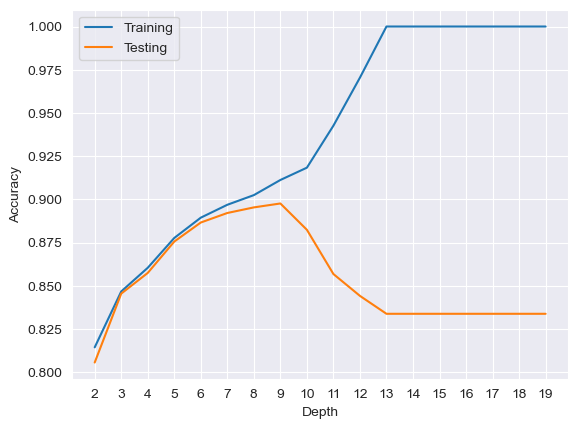

In [119]:
plt.plot(range(2, 20), accuracies_train, label='Training')
plt.plot(range(2, 20), accuracies_test, label='Testing')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.xticks(np.arange(2, 20, step=1))
plt.legend()
plt.show()

### Results
- depth:  
We learned that lowering the depth of the tree is beneficial to speed up the function and prevent overfitting and it can even improve the performance on the testing dataset, but only to a certain point, after which we start to get problems with overfitting. To be precise, the best depth for this dataset is 9 before data starts overfitting.
- min_samples_split:  
Same as with depth, raising min_sample_split helped in all areas, but also only to a certain point.
- threshold:  
Raising the threshold had same effects as the previous ones. The main benefit of tweaking this hyperparameter in combination 
- accuracy:  
In the best configuration out of the few we tested, highest accuracy we achieved on the testing dataset was 89.5%.

# Phase 3-2: Training and evaluating classifiers
First we transform data based on decisions from Phase 2 combined with notes from lecturer on phase 2.

In [119]:
transformation_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('transformer', QuantileTransformer(output_distribution='normal'))
])

transformed_X_train, transformed_X_test = transformation_pipeline.fit_transform(X_train), transformation_pipeline.fit_transform(X_test)


## 3-2A: Decision Tree Classifier

In [130]:
decision_tree = tree.DecisionTreeClassifier()
decision_tree.fit(transformed_X_train, y_train)
y_pred = decision_tree.predict(transformed_X_test)
y_pred_train = decision_tree.predict(transformed_X_train)
show_metrics(y_pred_train, y_pred, y_train, y_test)

,Train,Test
Precision True,1.0,0.777496
Precision False,1.0,0.870341
Precision Weighted,1.0,0.835272
Recall True,1.0,0.863092
Recall False,1.0,0.788165
Recall Weighted,1.0,0.834791
Accuracy,1.0,0.834791


The default model is obviously overfitted, so we change some hyperparameters. Let's try to check a few of them to improve slightly. We will do a more exhaustive search later.

In [168]:
grid_search_tree = GridSearchCV(
    tree.DecisionTreeClassifier(), 
    param_grid={
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
    }, 
    cv=5, # 5-fold cross validation
    verbose=1, # prints out progress
    n_jobs=-1 # allows all cores to run in parallel
)
grid_search_tree.fit(transformed_X_train, y_train)
print(grid_search_tree.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
{'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [169]:
decision_tree = grid_search_tree.best_estimator_

In [208]:
y_pred = decision_tree.predict(transformed_X_test)
y_pred_train = decision_tree.predict(transformed_X_train)
tree_metrics = show_metrics(y_pred_train, y_pred, y_train, y_test)
tree_metrics

,Train,Test
Precision True,0.902787,0.893715
Precision False,0.919165,0.900748
Precision Weighted,0.913108,0.898092
Recall True,0.945751,0.940135
Recall False,0.858300,0.829331
Recall Weighted,0.913406,0.898283
Accuracy,0.913406,0.898283


By optimizing the hyperparameters, we managed to get the accuracy up to 89.8% on the testing dataset, which is up by 6.4% from the default model.

## 3-2B: Logistic Regression Classifier

In [192]:
logistic_regressor = LogisticRegression()
logistic_regressor.fit(transformed_X_train, y_train)
y_pred = logistic_regressor.predict(transformed_X_test)
y_pred_train = logistic_regressor.predict(transformed_X_train)
show_metrics(y_pred_train, y_pred, y_train, y_test)

,Train,Test
Precision True,0.912392,0.916123
Precision False,0.916914,0.909136
Precision Weighted,0.915242,0.911775
Recall True,0.951922,0.953149
Recall False,0.853044,0.843053
Recall Weighted,0.915350,0.911565
Accuracy,0.915350,0.911565


In [38]:
grid_search_log_reg = GridSearchCV(
    LogisticRegression(), 
    param_grid={
    'penalty': ['l1', 'l2', 'elasticnet', None], # we will get some warnings for unsupported combinations, but we can ignore them
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'lbfgs', 'saga', 'newton-cholesky'],
    'class_weight': ['balanced', None],
    'max_iter': [100, 1000]
    }, 
    cv=5, 
    n_jobs=-1
)
grid_search_log_reg.fit(transformed_X_train, y_train)
logistic_regressor = grid_search_log_reg.best_estimator_

C:\Users\marti\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
980 fits failed out of a total of 2240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\marti\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\marti\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\marti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1172, in fit
    solver

In [39]:
y_pred = logistic_regressor.predict(transformed_X_test)
y_pred_train = logistic_regressor.predict(transformed_X_train)
logistic_regression_metrics = show_metrics(y_pred_train, y_pred, y_train, y_test)
logistic_regression_metrics

,Train,Test
Precision True,0.912778,0.918463
Precision False,0.916708,0.907921
Precision Weighted,0.915255,0.911903
Recall True,0.952179,0.954711
Recall False,0.852606,0.840480
Recall Weighted,0.915350,0.911565
Accuracy,0.915350,0.911565


In [207]:
grid_search_log_reg.best_params_

{'C': 0.01,
 'class_weight': None,
 'max_iter': 100,
 'penalty': 'l2',
 'solver': 'lbfgs'}

Unlike with the decision tree, the logistic regression model didn't improve with hyperparameter optimization. The accuracy stayed nearly the same, same for the precision and recall.

## 3-2 B, C and E: Comparison

### First, let's compare speed of fitting the models
We need to create new unfitted models:

In [14]:
benchmark_id3 = ID3classifier(max_depth=9, min_samples_split=50)
benchmark_tree = tree.DecisionTreeClassifier(**{'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}) 
benchmark_log_reg = LogisticRegression(**{'C': 0.01, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'})

In [229]:
def print_runtimes(*_predictors):
    for _predictor in _predictors:
        _time_before = time()
        _predictor.fit(transformed_X_train, y_train)
        _time_after = time()
        print(f"{_predictor.__class__.__name__}:", _time_after - _time_before)
    
    
print_runtimes(benchmark_id3, 
               benchmark_tree, 
               benchmark_log_reg)

ID3classifier: 5.810088396072388
DecisionTreeClassifier: 0.2834305763244629
LogisticRegression: 0.02513885498046875


ID3classifier is the slowest by far, 20 times slower than scikit DecisionTreeClassifier, but that's to be expected as those libraries are greatly optimized. Logistic regression is the fastest, being 14 times faster than DecisionTreeClassifier. 
The times may vary depending on the hardware, they may scale differently with the size of the data and would work differently had we chosen different hyperparameters. But the general trend, where speed go like ID3classifier\<DecisionTreeClassifier\<LogisticRegression, should stay the same.

In [13]:
def compare_metrics(*_predictors: BaseEstimator):
    _df = pd.DataFrame()
    for _predictor in _predictors:
        _y_pred = _predictor.predict(transformed_X_test)
        _y_pred_train = _predictor.predict(transformed_X_train)
        _metrics = show_metrics(_y_pred_train, _y_pred, y_train, y_test)
        _metrics.columns = [f'{x}_{"".join(filter(lambda _char: _char.isupper() or _char.isdigit() ,_predictor.__class__.__name__))}' for x in _metrics.columns]
        _df = pd.concat([_df, _metrics], axis=1)
    return _df

In [241]:
compare_metrics(benchmark_id3, benchmark_tree, benchmark_log_reg)

,Train_ID3,Test_ID3,Train_DTC,Test_DTC,Train_LR,Test_LR
Precision True,0.900811,0.901718,0.902787,0.891344,0.912992,0.918616
Precision False,0.903325,0.891614,0.919165,0.901049,0.916718,0.908821
Precision Weighted,0.902395,0.895430,0.913108,0.897384,0.915340,0.912520
Recall True,0.946523,0.946382,0.945751,0.938574,0.952307,0.954711
Recall False,0.827420,0.810463,0.858300,0.830189,0.852606,0.842196
Recall Weighted,0.902471,0.895044,0.913406,0.897635,0.915431,0.912213
Accuracy,0.902471,0.895044,0.913406,0.897635,0.915431,0.912213


From the cell above, we see Logistic Regression is not only the fastest, but has the best performance in all the metrics.  
ID3 is marginally worse, but we can account that to the fact, we didn't optimize the hyperparameters as much as with the other models, as it would take way more time.

## 3-2D: Vizualization of the Decision Trees

First we visualize the ID3 classifier. I chose to visualize it with a dataframe. Each column is a layer of the binary tree. Each node has a value in the row. If it has children, the left child is right next to it and the right child is the next non-empty value below. If the node is a leaf, it's marked with "Result: 0" or "Result: 1".

In [255]:
visualize_id3 = ID3classifier(max_depth=5)
visualize_id3.fit(transformed_X_train, y_train)
visualize_id3.visualize()

,Depth 0,Depth 1,Depth 2,Depth 3,Depth 4,Depth 5
0,Column 1 split at -0.0082,Column 20 split at 0.3493,Column 20 split at -0.1992,Column 3 split at -0.2062,Column 20 split at -0.5272,Result: 1
1,,,,,,Result: 1
2,,,,,Column 3 split at 0.4508,Result: 1
3,,,,,,Result: 0
4,,,,Column 26 split at 0.0615,Column 16 split at 0.0457,Result: 1
5,,,,,,Result: 1
6,,,,,Column 20 split at 0.0779,Result: 1
7,,,,,,Result: 1
8,,,Column 14 split at 0.006,Column 28 split at 0.0249,Column 19 split at -0.1771,Result: 1
9,,,,,,Result: 1


For the DecisionTreeClassifier, we will use the default function from scikit-learn.

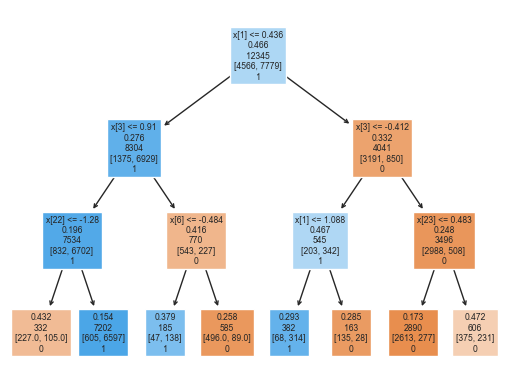

In [277]:
visualize_tree = tree.DecisionTreeClassifier(max_depth=3) # only depth 3 so it's legible
visualize_tree.fit(transformed_X_train, y_train)
tree.plot_tree(visualize_tree, label='none', filled=True,class_names=['0', '1'])
plt.show()

We can see points at which the tree splits and the values at which it splits. We can what value we get if we stop at a certain node. We can also see counts in each of the nodes.

# Phase 3-3: Optimization

## 3-3A: Hyperparameter tuning

### DecisionTreeClassifier

Let's try a little more exhaustive search for the hyperparameters, testing more options.

In [11]:
grid_search_tree2 = GridSearchCV(
    tree.DecisionTreeClassifier(), 
    param_grid={
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 6, 7, 8, 9],
    'min_samples_split': [2, 5, 10, 25, 35, 50, 70],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'max_features': [None, 'sqrt', 'log2']
    }, 
    cv=5,       # 5-fold cross validation
    verbose=1,  # prints out progress
    n_jobs=-1   # allows all cores to run in parallel
)
grid_search_tree2.fit(transformed_X_train, y_train)
grid_search_tree2.best_params_

Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


{'criterion': 'entropy',
 'max_depth': 7,
 'max_features': None,
 'min_samples_leaf': 4,
 'min_samples_split': 35}

Let's compare unoptimized DecisionTreeClassifier with slightly optimized, with the best one we found.

In [16]:
def compare_tree_metrics(*_predictors: BaseEstimator):
    _names = ['Base', 'Better', 'Best']
    _df = pd.DataFrame()
    for _index, _predictor in enumerate(_predictors):
        _predictor.fit(transformed_X_train, y_train)
        _y_pred = _predictor.predict(transformed_X_test)
        _y_pred_train = _predictor.predict(transformed_X_train)
        _metrics = show_metrics(_y_pred_train, _y_pred, y_train, y_test)
        _metrics.columns = [f'{x}_{_names[_index]}' for x in _metrics.columns]
        _df = pd.concat([_df, _metrics], axis=1)
    return _df

compare_tree_metrics(
    tree.DecisionTreeClassifier(),
    tree.DecisionTreeClassifier(**{'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}), 
    tree.DecisionTreeClassifier(**{'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 35}),
)

,Train_Base,Test_Base,Train_Better,Test_Better,Train_Best,Test_Best
Precision True,1.0,0.782128,0.902787,0.894347,0.918044,0.909851
Precision False,1.0,0.870816,0.919165,0.899900,0.922609,0.907011
Precision Weighted,1.0,0.837317,0.913108,0.897803,0.920920,0.908084
Recall True,1.0,0.866736,0.945751,0.940656,0.954750,0.949505
Recall False,1.0,0.788165,0.858300,0.827616,0.863557,0.839623
Recall Weighted,1.0,0.837059,0.913406,0.897959,0.921021,0.908001
Accuracy,1.0,0.837059,0.913406,0.897959,0.921021,0.908001


As we can see, the difference between the base model and the slightly optimized one is very big at 6%, with difference between the slightly optimized and the best one being 1%.  
Based on this findings, we can see the hyperparameter optimization is very important, but has diminishing returns after a certain point.

We aren't going to tune Logistic Regression further, as it didn't improve last time either.

## 3-3B: Ensemble Learning

### Random Forest
Random forest is a type of bagging ensemble method, that bags together multiple decision trees. It's a great way to improve the performance of the model.

In [246]:
forest = RandomForestClassifier(max_depth=10)
forest.fit(transformed_X_train, y_train)
y_pred = forest.predict(transformed_X_test)
y_pred_train = forest.predict(transformed_X_train)
show_metrics(y_pred_train, y_pred, y_train, y_test)

,Train,Test
Precision True,0.933179,0.921124
Precision False,0.932296,0.924395
Precision Weighted,0.932623,0.923160
Recall True,0.962977,0.954711
Recall False,0.880859,0.871355
Recall Weighted,0.932604,0.923226
Accuracy,0.932604,0.923226


We can see that immediately, the model is outperforming the individual models we tested so far with 92.3% accuracy. Let's see how we can improve it further with hyperparameter optimization.

In [31]:
grid_search_forest = GridSearchCV(
    RandomForestClassifier(), 
    param_grid={
    'n_estimators': [25, 50, 100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [11, 12, 13, 14, 15, 16, 17, 18],
    'min_samples_split': [2, 5, 10, 25, 50],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],           # we don't use None, as it would take way too long for too little benefit 
    'random_state': [66]                        # to make the results reproducible
    }, 
    cv=10,      # 10-fold cross validation, as we have high possible max_depth and low cv might lead to overfitting 
    n_jobs=-1
)
grid_search_forest.fit(transformed_X_train, y_train)
grid_search_forest.best_params_

{'criterion': 'entropy',
 'max_depth': 16,
 'max_features': 'sqrt',
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'n_estimators': 150}

features 'max_features': 'sqrt' and 'min_samples_leaf': 1 are the default so we don't need to pass them later

In [32]:
y_pred = grid_search_forest.best_estimator_.predict(transformed_X_test)
y_pred_train = grid_search_forest.best_estimator_.predict(transformed_X_train)
show_metrics(y_pred_train, y_pred, y_train, y_test)

,Train,Test
Precision True,0.972845,0.923636
Precision False,0.945006,0.924509
Precision Weighted,0.955303,0.924180
Recall True,0.985217,0.956273
Recall False,0.902322,0.871355
Recall Weighted,0.954557,0.924198
Accuracy,0.954557,0.924198


The hyperparameter optimization improved the model, but only by 0.1%. The training data accuracy improved by 2.2%, but that's due to higher max_depth which makes the model more prone to overfitting.

### Voting Classifier
Step 1: Chose models for the ensemble. We will use the best models we found so far.

In [9]:
model1 = RandomForestClassifier(**{'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 5, 'n_estimators': 150, 'random_state': [66]})
model2 = tree.DecisionTreeClassifier(**{'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 35})
model3 = LogisticRegression(**{'C': 0.01, 'class_weight': None, 'max_iter': 300, 'penalty': 'l2', 'solver': 'lbfgs'})
model4 = GradientBoostingClassifier()

In [10]:
voting_classifier = VotingClassifier(estimators=[('rf', model1), ('dt', model2), ('lr', model3), ('gb', model4)], voting='soft', n_jobs=-1)

In [11]:
voting_classifier.fit(transformed_X_train, y_train)
y_pred = voting_classifier.predict(transformed_X_test)
y_pred_train = voting_classifier.predict(transformed_X_train)
show_metrics(y_pred_train, y_pred, y_train, y_test)

,Train,Test
Precision True,0.926089,0.922374
Precision False,0.929132,0.921687
Precision Weighted,0.928006,0.921946
Recall True,0.958992,0.955752
Recall False,0.875383,0.866209
Recall Weighted,0.928068,0.921931
Accuracy,0.928068,0.921931


The Random Forest is likely boosting the performance of the model, so let's try combining only the other three.

In [125]:
voting_classifier_no_rf = VotingClassifier(estimators=[('dt', model2), ('lr', model3), ('gb', model4)], voting='soft', n_jobs=-1)
voting_classifier_no_rf.fit(transformed_X_train, y_train)
y_pred = voting_classifier_no_rf.predict(transformed_X_test)
y_pred_train = voting_classifier_no_rf.predict(transformed_X_train)
show_metrics(y_pred_train, y_pred, y_train, y_test)

,Train,Test
Precision True,0.922380,0.919043
Precision False,0.925765,0.916500
Precision Weighted,0.924513,0.917461
Recall True,0.957064,0.954191
Recall False,0.869251,0.856775
Recall Weighted,0.924585,0.917396
Accuracy,0.924585,0.917396


The ensemble model performed slightly worse than the best model so far (random forest) at 92.1% accuracy, but better than any other individual model we tested.

## 3-3C: Cross Validation
We already used it in grid search, but in this section we focus solely on the cross validation.


We use cross validation to see how well the models generalize or if they are overfitting to the noise in the training data.  
We decided for a 10-fold cross validation, as it's a good balance between time and accuracy.

In [12]:
kfold = KFold(n_splits=10, shuffle=True, random_state=66)
votingCrossVal = cross_val_score(voting_classifier, transformed_X_train, y_train, cv=5, n_jobs=-1)
forestCrossVal = cross_val_score(model1, transformed_X_train, y_train, cv=5, n_jobs=-1)
treeCrossVal = cross_val_score(model2, transformed_X_train, y_train, cv=5, n_jobs=-1)
logRegCrossVal = cross_val_score(model3, transformed_X_train, y_train, cv=5, n_jobs=-1)

In [14]:
print(f"""Voting classifier: {votingCrossVal.mean()}
Random forest: {forestCrossVal.mean()}
Decision tree: {treeCrossVal.mean()}
Logistic regression: {logRegCrossVal.mean()}""")

Voting classifier: 0.9217496962332928
Random forest: 0.9263669501822601
Decision tree: 0.9074929121101661
Logistic regression: 0.9149453219927096


The results are as follows:  
Voting classifier: 92.17% accuracy  
Random forest: 92.64% accuracy  
Decision tree: 90.75% accuracy  
Logistic regression: 91.49% accuracy

That only confirms our previous results that Random Forest is the best model for this dataset.  

## 3-3D: Showcasing absence of overfitting for the best model

The best model we have chosen is the Random Forest. We have already proven that it's not overfitting throughout the notebook, but we will redo the methods again to have it all in one place.

### Learning curve

In [74]:
accuracies_train = []
accuracies_test = []
for forest_depth in range(6, 23):
    temp_forest = RandomForestClassifier(**{'criterion': 'entropy', 'max_depth': forest_depth, 'min_samples_split': 5, 'n_estimators': 150, 'random_state': 66})
    temp_forest.fit(transformed_X_train, y_train)
    y_pred = temp_forest.predict(transformed_X_test)
    y_pred_train = temp_forest.predict(transformed_X_train)
    accuracies_train.append(accuracy_score(y_train, y_pred_train))
    accuracies_test.append(accuracy_score(y_test, y_pred))

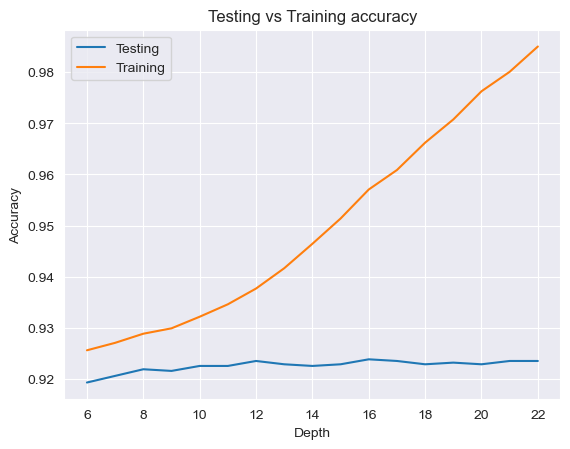

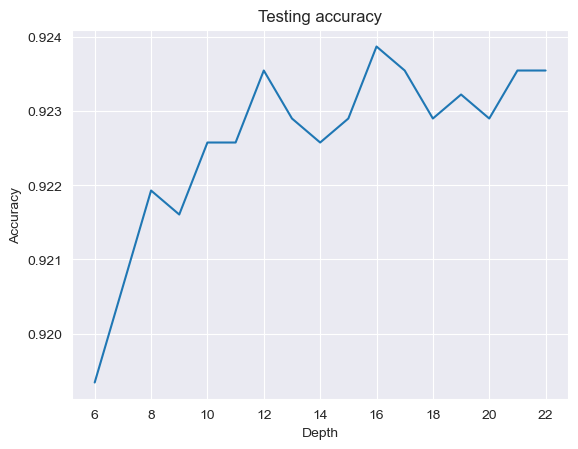

In [78]:
plt.plot(range(6, 23), accuracies_test, label='Testing')
plt.plot(range(6, 23), accuracies_train, label='Training')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Testing vs Training accuracy')
plt.legend()
plt.show()
plt.plot(range(6, 23), accuracies_test, label='Testing')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Testing accuracy')
plt.show()

From the graph, we can see that the accuracy is growing way faster in the training dataset than in the testing dataset, which is usually a sign of overfitting, but the testing accuracy is still rising, peaking at 16.

### Validating on unseen data

When we run predictions on the testing data, we can see that the accuracy isn't much different from the training data. It's slightly lower, but that's to be expected. 

In [79]:
forest = RandomForestClassifier(**{'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 5, 'n_estimators': 150, 'random_state': 66})
forest.fit(transformed_X_train, y_train)
y_pred = forest.predict(transformed_X_test)
y_pred_train = forest.predict(transformed_X_train)
show_metrics(y_pred_train, y_pred, y_train, y_test)

,Train,Test
Precision True,0.977294,0.922797
Precision False,0.946532,0.924471
Precision Weighted,0.957910,0.923839
Recall True,0.987659,0.955752
Recall False,0.904950,0.871355
Recall Weighted,0.957068,0.923874
Accuracy,0.957068,0.923874


### Cross validation

In [80]:
forestCrossVal = cross_val_score(forest, transformed_X_train, y_train, cv=5, n_jobs=-1)
forestCrossVal.mean()

0.9261239368165249

We can see fairly high accuracy in the cross validation, which is a good sign that the model is generalizing well.

### Measures taken to prevent overfitting
We have taken several measures to prevent overfitting:  
- Limiting the depth of the tree
- Using ensemble methods, which are less prone to overfitting

# 3-4: Summary

## 3-4A: Handling Null Values and Outliers
Our way of dealing with these was to impute neutral values for null values and clip outliers to 1.5IQR distance from 1st and 3rd quartile.  
Let's see if it was a good decision. 

First we get the data without our preprocessing.

In [87]:
unmodified_data = iterative_reformat(pd.read_csv('data/connections.csv', sep='\t', keep_default_na=False, na_values=''), 
                           pd.read_csv('data/processes.csv', sep='\t', keep_default_na=False, na_values=''), do_clean=False)
unmodified_X_train, unmodified_X_test, unmodified_y_train, unmodified_y_test = train_test_split(unmodified_data.drop(columns=['mwra']), unmodified_data['mwra'], test_size=0.2, random_state=69)

We test the best model on the unmodified data and compare the results.

In [90]:
forest = RandomForestClassifier(**{'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 5, 'n_estimators': 150, 'random_state': 66})
forest.fit(unmodified_X_train, unmodified_y_train)
y_pred = forest.predict(unmodified_X_test)
y_pred_train = forest.predict(unmodified_X_train)
show_metrics(y_pred_train, y_pred, unmodified_y_train, unmodified_y_test)

,Train,Test
Precision True,0.977499,0.922727
Precision False,0.945956,0.924006
Precision Weighted,0.957623,0.923523
Recall True,0.987788,0.955752
Recall False,0.903855,0.870497
Recall Weighted,0.956744,0.923550
Accuracy,0.956744,0.923550


The difference in accuracies of unmodified and modified data is only 0.03%, which is a very small difference, but the preprocessed ones are still slightly better. 

Let's check a different way of managing null values and outliers to see if it would be better.

In [99]:
differently_modified_data = iterative_reformat(pd.read_csv('data/connections.csv', sep='\t', keep_default_na=False, na_values=''),
                                               pd.read_csv('data/processes.csv', sep='\t', keep_default_na=False, na_values=''), do_clean=False)
# drop rows with null values
differently_modified_data.dropna(inplace=True)
# drop rows with outliers
for column in differently_modified_data.columns:
    q1 = differently_modified_data[column].quantile(0.25)
    q3 = differently_modified_data[column].quantile(0.75)
    iqr = q3 - q1
    differently_modified_data = differently_modified_data[(differently_modified_data[column] >= q1 - 1.5*iqr) & (differently_modified_data[column] <= q3 + 1.5*iqr)]
    
diff_mod_X_train, diff_mod_X_test, diff_mod_y_train, diff_mod_y_test = train_test_split(differently_modified_data.drop(columns=['mwra']), differently_modified_data['mwra'], test_size=0.2, random_state=69)

In [100]:
forest = RandomForestClassifier(**{'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 5, 'n_estimators': 150, 'random_state': 66})
forest.fit(diff_mod_X_train, diff_mod_y_train)
y_pred = forest.predict(diff_mod_X_test)
y_pred_train = forest.predict(diff_mod_X_train)
show_metrics(y_pred_train, y_pred, diff_mod_y_train, diff_mod_y_test)

,Train,Test
Precision True,0.981829,0.914579
Precision False,0.948852,0.925826
Precision Weighted,0.961273,0.921477
Recall True,0.989805,0.948204
Recall False,0.911699,0.879518
Recall Weighted,0.960386,0.921643
Accuracy,0.960386,0.921643


The accuracy of the model is 0.2% lower than the model with our preprocessing.

#### Conclusion
Our preprocessing was good, as it improved the accuracy of the model slightly.

## 3-4B: Data transformation

We used MinMaxScaler and QuantileTransformer for the data transformation. Let's see if it was a good decision.

In [120]:
forest = RandomForestClassifier(**{'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 5, 'n_estimators': 150, 'random_state': 66})
forest.fit(transformed_X_train, y_train)
y_pred = forest.predict(transformed_X_test)
y_pred_train = forest.predict(transformed_X_train)
show_metrics(y_pred_train, y_pred, y_train, y_test)

,Train,Test
Precision True,0.977294,0.923636
Precision False,0.946532,0.924509
Precision Weighted,0.957910,0.924180
Recall True,0.987659,0.956273
Recall False,0.904950,0.871355
Recall Weighted,0.957068,0.924198
Accuracy,0.957068,0.924198


In [121]:
forest = RandomForestClassifier(**{'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 5, 'n_estimators': 150, 'random_state': 66})
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
y_pred_train = forest.predict(X_train)
show_metrics(y_pred_train, y_pred, y_train, y_test)

,Train,Test
Precision True,0.977300,0.923636
Precision False,0.946649,0.924509
Precision Weighted,0.957985,0.924180
Recall True,0.987659,0.956273
Recall False,0.905169,0.871355
Recall Weighted,0.957149,0.924198
Accuracy,0.957149,0.924198


We can see untransformed data has slightly higher accuracy than transformed ones, but only on training data, on testing data, the accuracy is the same.

We can check if any other transformation will yield better results.

In [112]:
pipeline = Pipeline([
    ('scaler1', None),
    ('scaler2', None),
    ('transformer1', None),
    ('transformer2', None),
    ('predictor', RandomForestClassifier(**{'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 5, 'n_estimators': 150, 'random_state': 66}))
])

param_grid = {
    'scaler1': [MinMaxScaler(), StandardScaler(), PowerTransformer(), None],
    'scaler2': [MinMaxScaler(), StandardScaler(), PowerTransformer(), None],
    'transformer1': [QuantileTransformer(output_distribution='normal'), QuantileTransformer(output_distribution='uniform'), PowerTransformer(), None],
    'transformer2': [QuantileTransformer(output_distribution='normal'), QuantileTransformer(output_distribution='uniform'), PowerTransformer(), None]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=True, n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


{'scaler1': MinMaxScaler(),
 'scaler2': MinMaxScaler(),
 'transformer1': QuantileTransformer(output_distribution='normal'),
 'transformer2': QuantileTransformer(output_distribution='normal')}

In [122]:
best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)
y_pred_train = best_pipeline.predict(X_train)
show_metrics(y_pred_train, y_pred, y_train, y_test)

,Train,Test
Precision True,0.977525,0.923636
Precision False,0.946539,0.924509
Precision Weighted,0.958000,0.924180
Recall True,0.987788,0.956273
Recall False,0.904950,0.871355
Recall Weighted,0.957149,0.924198
Accuracy,0.957149,0.924198


The best pipeline we found has the same accuracy on both datasets as not using any transformation at all, with other metrics also changed only very slightly.  
The testing dataset accuracy remained the same across all methods, so we might as well use the simplest unporcessed data.

## 3-4C: Feature selection, algorithm choices, hyperparameter tuning and ensemble learning

### Feature selection
For feature selection, we haven't been using any methods as the tree algorithms (be it ID3, DecisionTreeClassifier and Random Forest) were seleccting the best features themselves.

In [124]:
feature_selector = SelectKBest(mutual_info_classif, k=10)
best_features = feature_selector.fit_transform(X_train, y_train)
test_features = feature_selector.transform(X_test)
forest = RandomForestClassifier(**{'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 5, 'n_estimators': 150, 'random_state': 66})
forest.fit(best_features, y_train)
y_pred = forest.predict(test_features)
y_pred_train = forest.predict(best_features)
show_metrics(y_pred_train, y_pred, y_train, y_test)

,Train,Test
Precision True,0.960517,0.922727
Precision False,0.940791,0.924006
Precision Weighted,0.948087,0.923523
Recall True,0.978403,0.955752
Recall False,0.895094,0.870497
Recall Weighted,0.947590,0.923550
Accuracy,0.947590,0.923550


As we see, the accuracy only got lower, as the estimator had fewer features to choose from at each split. 

### Algorithm choices
We have tested 4 different algorithms: DecisionTreeClassifier, LogisticRegression, RandomForestClassifier and VotingClassifier(combining the previous three + GradientBoostingClassifier).  
We compared by multiple metrics and we've seen that Random Forest is the best model for this dataset.

### Hyperparameter tuning
We have done hyperparameter tuning for all the models. In Logistic Regression, it didn't improve the model, but in the tree algorithms, it improved the models by a noticeable amount. We have tested a lot of combinations in Grid Search for all of the models.

### Ensemble learning
We have tested Random Forest and Voting Classifier. Both a few percent upgrade compared to individual models. Random Forest outperformed the Voting Classifier by 0.3% (0.7% if we couldn't use the Random Forest in the Voting Classifier).

## 3-4D: Choosing the best model

As mentioned many times, we have confidently chosen Random Forest as the best model for this dataset. It has the highest accuracy and other metrics, and is the most robust to prevent overfitting.

## 3-4E: Production pipeline

As we use no transformations and no feature selection, the pipeline is very simple with only the estimator. We only need to train the model and save it. We assume the iteration_reformat function is already called on the data and the pipeline receives a combined dataframe X_test.

In [126]:
import joblib

pipeline = Pipeline([
    ('estimator', RandomForestClassifier(**{'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 5, 'n_estimators': 150, 'random_state': 66}))
])

pipeline.fit(X_train, y_train)
joblib.dump(pipeline, 'pipeline.pkl')

['pipeline.pkl']